<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/leoenge/Lab-7/leoenge_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 7: Optimization and Learning**
**Leo Enge**

# **Abstract**

The purpose of this lab is to implement and test methods for finding stationary points of functions. This was done using the gradient descent method and Newton's method of optimization. The methods were tested for some chosen functions of two variables and they converged well.

# **About the code**

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Leo Enge (leoe@kth.se)
# Discussed problems with Christoffer Ejemyr

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

When looking for the minimum of a function an intuitive way to do it would to be start in a point and then move in the direction of the greatest descent. This can be realised by the gradient descent method were one move in the oppostite direction of the gradient in each iteration.

If one is only interested in finding a stationart point this is equivalent to finding a point in which the gradient i zero. This can be done using Newton's method for finding roots.

Both of these two method are implemented and tested in this report.



# **Methods**

## Gradient Descent Method
We begin by implementing a function for calculating the gradient $\nabla f$ of a function $f$ in a point $x$.

In [0]:
def gradient(f, x):
    dx = 1e-6
    hs = np.diag(np.full(x.size, dx))
    return np.array([f(x+h)-f(x) for h in hs])/dx

Using the ```gradient``` function as a subroutine we implement the gradient descent method following algorithm 15.1 in the lecture notes. We use the constant step multiplier $\alpha = 0.01$ instead of changing it for every iteration. Among other things the function returns ```True``` if the iteration succeeds, in other words if $\| \nabla f(x)\| < \text{TOL}$ for the calculated stationary point $x$ and some tolerance TOL.

In [0]:
def gradient_descent_method(f, x0, TOL):
    x = x0
    alpha = 0.01
    no_of_iterations = 0
    max_iterations = 1000
    
    Df = gradient(f, x)
    while(np.linalg.norm(Df) > TOL and no_of_iterations < max_iterations):
        x -= alpha*Df
        Df = gradient(f, x)
        no_of_iterations += 1
    
    return x, no_of_iterations, np.linalg.norm(Df)<=TOL
        

### Test of Gradient Descent Method
We test the gradient descent method for the three different two-variable functions
\begin{align}
f(x,y) &= x^2 + y^2 +1 \\
f(x,y) &= (x-1)^2 + 1 \\
f(x,y) &= \cos{\frac{\pi x}{2}} + \sin{\pi x}.
\end{align}
For each function we use a set of random initial points. We then plot the function together with the calculated minimized points. If all the iterations returned ```True``` we return ```True```, otherwise we return ```False```.

In [0]:
def test_gradient_descent_method():
    #Uncomment this if using Jupyter notebook and not Colab for interactive plots.
    #%matplotlib notebook
    TOL = 1e-5
    
    functions = {'f(x,y) = x^2 + y^2 + 1': (lambda x: x[0]**2 + x[1]**2 + 1, [-3,3]),
                'f(x,y) = (x-1)^2 + 1': (lambda x: (x[0]-1)**2 + 1, [-3,3]),
                'f(x,y) = cos(pi*x/2) + sin(pi*x)': (lambda x: np.cos(np.pi*x[0]/2) + np.sin(np.pi*x[1]) + 1, [-3,3])}
    plots = {}
    
    for f_name, (f,limits) in functions.items():
        x = np.outer(np.linspace(limits[0], limits[1], 50), np.ones(50))
        y = x.copy().T
        plots[f_name] = (plt.figure(), plt.axes(projection='3d'))
        
        #Test for multiple random initial points
        for _ in range(5):
            x0 = np.random.random(2)
            x_approx, no_of_iterations, converged = gradient_descent_method(f, x0, TOL)
            if not converged: return False
            plots[f_name][1].scatter(x_approx[0], x_approx[1], f(x_approx), color='red')
            
        z = f([x, y])
        plots[f_name][1].plot_surface(x, y, z,cmap='viridis', edgecolor='none', alpha=0.3) 
        plots[f_name][1].set_title(f_name)
        
    return True 

## Newton's Method for Optimization
We begin by calculating the Hessian.

In [0]:
def hessian(f, x, Df=None):
    dx = 1e-6
    hs = np.diag(np.full(x.size, dx))
    if Df is None:
        Df = gradient(f,x)
    Df_xphs = [gradient(f,x+h) for h in hs]
    return np.array([Df_xph-Df for Df_xph in Df_xphs])/dx

We then use the ```Hessian``` function as a subroutine when implementing Newton's optimization method. We implement it in much the same way as algorithm 15.3 in the lecture notes. Just as for the gradient descent method we use the constant step multiplier $\alpha = 0.001$. Among other things the function returns ```True``` if the iteration succeeds, in other words if $\| \nabla f(x)\| < \text{TOL}$ for the calculated stationary point $x$ and some tolerance TOL.

In [0]:
def newtons_method(f, x0, TOL):
    x = x0
    alpha = 0.01
    Df = gradient(f,x)
    no_of_iterations = 0
    max_no_of_iterations = 1000
    while np.linalg.norm(Df)>TOL and no_of_iterations<max_no_of_iterations:
        H = hessian(f,x,Df=Df)
        try:
            dx = np.linalg.solve(H,-Df)
        except:
            print('Singular Hessian matrix:')
            print(H)
            return x, no_of_iterations, False
        x += alpha*dx
        Df = gradient(f,x)
    return x, no_of_iterations, np.linalg.norm(Df)<=TOL
    

### Test Newton's Method for Optimization
We test Newton's method for optimization for the three different two-variable functions
\begin{align}
f(x,y) &= x^2 + y^2 +1 \\
f(x,y) &= (x-1)^2 + xy + 1 \\
f(x,y) &= \cos{\frac{\pi x}{2}} + \sin{\pi x}.
\end{align}
For each function we use a set of random initial points. We then plot the function together with the calculated minimized points. If all the iterations returned ```True``` we return ```True```, otherwise we return ```False```.

In [0]:
def test_newtons_method():
    #Uncomment this if using Jupyter notebook and not Colab for interactive plots.
    #%matplotlib notebook
    TOL = 1e-3
    
    functions = {'f(x,y) = x^2 + y^2 + 1': (lambda x: x[0]**2 + x[1]**2 + 1, [-3,3]),
                'f(x,y) = (x-1)^2 + xy + 1': (lambda x: (x[0]-1)**2 + x[0]*x[1] + 1, [-4,4]),
                'f(x,y) = cos(pi*x/2) + sin(pi*x)': (lambda x: np.cos(np.pi*x[0]/2) + np.sin(np.pi*x[1]) + 1, [-3,3])}
    plots = {}
    
    for f_name, (f,limits) in functions.items():
        x = np.outer(np.linspace(limits[0], limits[1], 50), np.ones(50))
        y = x.copy().T
        plots[f_name] = (plt.figure(), plt.axes(projection='3d'))
        
        #Test for multiple random initial points
        for _ in range(5):
            x0 = np.random.random(2)
            x_approx, no_of_iterations, converged = newtons_method(f, x0, TOL)
            if not converged: return False
            #print(x_approx)
            #print(converged)
            plots[f_name][1].scatter(x_approx[0], x_approx[1], f(x_approx), color='red')
            
        z = f([x, y])
        plots[f_name][1].plot_surface(x, y, z,cmap='viridis', edgecolor='none', alpha=0.3)
        plots[f_name][1].set_title(f_name)
        
    return True

# **Results**

Looking at the plots of the functions, and maybe rotating them around a little one see that all the iterations converged to minimal points for the gradient descent method and to stationary points for Newton's method.

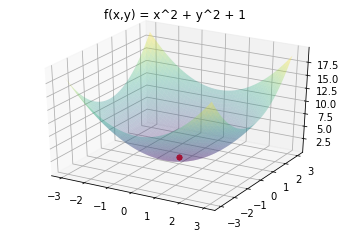

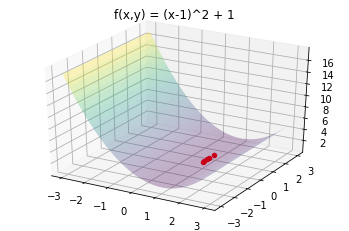

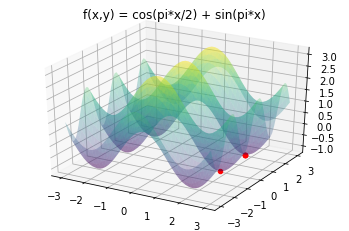

In [9]:
gradient_converged = test_gradient_descent_method()

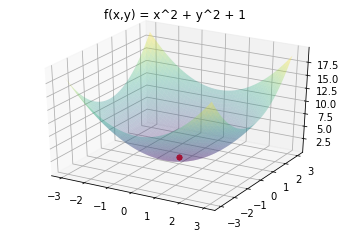

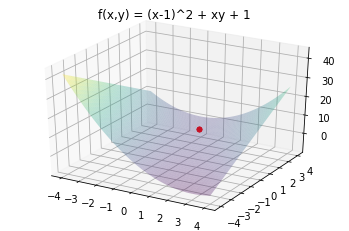

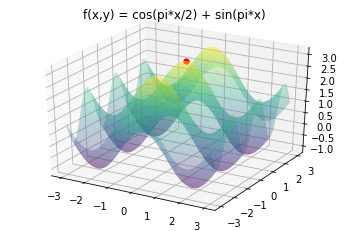

In [10]:
newton_converged = test_newtons_method()

# **Discussion**

The gradient descent method implemented requires that there is a inner minimal point in the direction of the descent, otherwise it will iterate for ever. For the function $f(x,y) = -x^2 - y^2$ the iteration will therefore never converge as the method is implemented now. This was therefore something that had to be taken into account we constructing the tests. Ideally one would test the method for a large set of random polynomials, but that could lead to a function for which the method does not converge. So instead a small set of ''nice'' functions was used for the test.

This behaviour of the method is something which should be improved. For example one can define a compact domain of the function and then find boudary points which are local minima.

The same kind of problem and reasoning holds for Newton's method as well.